# **EPIC NOTES**

In [0]:
!pip install seqeval
!pip install scispacy
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_sm-0.2.4.tar.gz

In [0]:
import pandas as pd
import numpy as np

from scipy import sparse

import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict

import matplotlib.pyplot as plt
%matplotlib inline
import itertools
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB

from seqeval.metrics import precision_score, recall_score, f1_score, classification_report
from keras.preprocessing.text import text_to_word_sequence
import pickle

import scispacy
import spacy
from scispacy.abbreviation import AbbreviationDetector
from spacy import displacy
import en_core_sci_sm

In [4]:
#Reading the csv file
df = pd.read_csv('Epic.csv', encoding = "ISO-8859-1")
df

,id,enroll,contact_date,department_name,doc_name,NOTE,Alcohol Use,Amount,Alcohol Abuse Current,Alcohol Abuse Past,Current Drug Use,Past Drug Use,Type,Current Smoker,Former Smoker,Amount.1,NOTES/COMMENTS,Mention_any,Mention_alcohol_use,Mention_alcohol_abuse_curr,Mention_alcohol_abuse_past,Mention_current_drug_use
0,2642,ENR-016576,1/9/2019,SHA PRIMARY CARE 5A,Progress Notes,ogress Note Subjective: Patient ID: xxx V xxx ...,N,NaN,NaN,NaN,Y,NaN,CRACK COCAINE,Y,NaN,SOME DAY SMOKER,NaN,1.0,1.0,0.0,0.0,1.0
1,2642,ENR-016576,1/13/2017,SHA PRIMARY CARE 5A,Progress Notes,ogress Note Subjective: Patient ID: xxx V xxx ...,N,NaN,NaN,NaN,Y,NaN,CRACK COCAINE,Y,NaN,SOME DAY SMOKER,NaN,1.0,1.0,0.0,0.0,1.0
2,2642,ENR-016576,1/15/2018,MEN EMERGENCY DEPT,ED Notes,Pt presents c/o atraumatic right arm pain x 1 ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0
3,2642,ENR-016576,1/15/2018,MEN EMERGENCY DEPT,ED Provider Notes,History Chief Complaint Patient presents with ...,N,NaN,NaN,NaN,Y,NaN,CRACK COCAINE,Y,NaN,SOME DAY SMOKER,NaN,1.0,1.0,0.0,0.0,1.0
4,2642,ENR-016576,1/20/2017,SHA PRIMARY CARE 5A,Progress Notes,ogress Note Subjective: Patient ID: xxx V xxx ...,N,NaN,NaN,NaN,Y,NaN,CRACK COCAINE,Y,NaN,SOME DAY SMOKER,NaN,1.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1819,40000,ENR-060097,12/26/2017,MOA HEMATOLOGY,Progress Notes,Progress Note Subjective: Patient ID: xxx L xx...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1820,40000,ENR-060097,12/27/2018,NaN,ED Attestation,ED Attending Attestation I have personally see...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1821,40000,ENR-060097,12/27/2018,NaN,ED Notes,Pt had returned from XR Pt placed in hallway P...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1822,40000,ENR-060097,12/27/2018,NaN,ED Provider Notes,History Chief Complaint Patient presents with ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df.describe()

,id,Mention_any,Mention_alcohol_use,Mention_alcohol_abuse_curr,Mention_alcohol_abuse_past,Mention_current_drug_use
count,1824.000000,1285.000000,1285.000000,1285.000000,1285.000000,1285.000000
mean,5161.366228,0.542412,0.266926,0.052918,0.077043,0.277043
std,9330.039616,0.498392,0.442526,0.223958,0.266763,0.447712
min,2593.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2645.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2667.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,2698.000000,1.000000,1.000000,0.000000,0.000000,1.000000
max,40000.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
selectlist =[ 'id', 'NOTE' , 'Alcohol Use', 'Current Drug Use', 'Current Smoker']
selectlist =[x for x in df.columns if x in selectlist]
df = df[selectlist]
df

,id,NOTE,Alcohol Use,Current Drug Use,Current Smoker
0,2642,ogress Note Subjective: Patient ID: xxx V xxx ...,N,Y,Y
1,2642,ogress Note Subjective: Patient ID: xxx V xxx ...,N,Y,Y
2,2642,Pt presents c/o atraumatic right arm pain x 1 ...,NaN,NaN,NaN
3,2642,History Chief Complaint Patient presents with ...,N,Y,Y
4,2642,ogress Note Subjective: Patient ID: xxx V xxx ...,N,Y,Y
...,...,...,...,...,...
1819,40000,Progress Note Subjective: Patient ID: xxx L xx...,NaN,NaN,NaN
1820,40000,ED Attending Attestation I have personally see...,NaN,NaN,NaN
1821,40000,Pt had returned from XR Pt placed in hallway P...,NaN,NaN,NaN
1822,40000,History Chief Complaint Patient presents with ...,NaN,NaN,NaN


In [0]:
nlp = en_core_sci_sm.load()

In [0]:
notes = df['NOTE'].tolist()

X_ner = []
for i in range(len(df)):
    text = notes[i]
    doc = nlp(text)
    #print(doc.ents)

    a = [i.text for i in doc.ents]
    a = ''.join(a)
    X_ner.append(a)

In [0]:
notes_len =[]
for i in range(len(X_ner)):
    notes_len.append(len(X_ner[i]))

In [0]:
df['Note Length'] = notes_len

In [21]:
plt2 = go.Histogram(x = notes_len)
lyt2 = go.Layout(title="Frequency of Notes Length", xaxis=dict(title='Notes Length', range=[0,10000]), yaxis=dict(title='Frequency'))
fig2 = go.Figure(data=[plt2], layout=lyt2)
fig2.show()

In [22]:
df.drop('NOTE', axis = 1, inplace = True)
df.insert(1, 'NOTE', X_ner)

df

,id,NOTE,Alcohol Use,Current Drug Use,Current Smoker,Note Length
0,2642,ogressNote SubjectivePatient IDfemaleChief Com...,N,Y,Y,3355
1,2642,ogressNote SubjectivePatient IDfemaleChief Com...,N,Y,Y,2566
2,2642,c/o atraumaticdaymovement,NaN,NaN,NaN,25
3,2642,HistoryChief ComplaintPatientArm Pain rightatr...,N,Y,Y,1499
4,2642,ogressNote SubjectivePatient IDfemaleChief Com...,N,Y,Y,3435
...,...,...,...,...,...,...
1819,40000,Progress Note SubjectivePatient IDLfemaleh/o g...,NaN,NaN,NaN,2127
1820,40000,EDAttendingAttestation IpersonallypatientIcare...,NaN,NaN,NaN,219
1821,40000,PtXRhallwayhallacityPtAMAIVnorthernbedside,NaN,NaN,NaN,42
1822,40000,HistoryChief ComplaintPatientChest Pain hxPEwe...,NaN,NaN,NaN,2654


# **Models**

In [0]:
# Linear svc, knn, naive bayes
def linsvc(x,y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state = 11)
    classf = LinearSVC()
    classf.fit(x_train, y_train)
    pred = classf.predict(x_test)
    print("### Linear SVC: ###")
    consolidatedMeasure = precision_recall_fscore_support(y_test.to_numpy().astype(int), pred.astype(int), average = 'binary')
    recallMeasure = round(consolidatedMeasure[0]*100,2)
    precisionMeasure =  round(consolidatedMeasure[1]*100,2)
    F1score = round(consolidatedMeasure[2]*100,2)
    print("Accuracy:",round(accuracy_score(y_test, pred)*100,2),'%')
    print("F1 score:",F1score,'%')
    print("Precision:",precisionMeasure,'%')
    print("Recall:", recallMeasure,'%','\n')
    return(y_test, pred)

def revknn(x,y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state = 11)
    classf = KNeighborsClassifier(n_neighbors=2)
    classf.fit(x_train, y_train)
    pred = classf.predict(x_test)
    print("### kNN: ###")
    consolidatedMeasure = precision_recall_fscore_support(y_test.to_numpy().astype(int), pred.astype(int), average = 'binary')
    recallMeasure = round(consolidatedMeasure[0]*100,2)
    precisionMeasure =  round(consolidatedMeasure[1]*100,2)
    F1score = round(consolidatedMeasure[2]*100,2)
    print("Accuracy:",round(accuracy_score(y_test, pred)*100,2),'%')
    print("F1 score:",F1score,'%')
    print("Precision:",precisionMeasure,'%')
    print("Recall:", recallMeasure,'%','\n')
    return(y_test, pred)

def revnb(x,y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state = 11)
    classf = MultinomialNB()
    classf.fit(x_train, y_train)
    pred = classf.predict(x_test)
    print("### Naive Bayes: ###")
    consolidatedMeasure = precision_recall_fscore_support(y_test.to_numpy().astype(int), pred.astype(int), average = 'binary')
    recallMeasure = round(consolidatedMeasure[0]*100,2)
    precisionMeasure =  round(consolidatedMeasure[1]*100,2)
    F1score = round(consolidatedMeasure[2]*100,2)
    print("Accuracy:",round(accuracy_score(y_test, pred)*100,2),'%')
    print("F1 score:",F1score,'%')
    print("Precision:",precisionMeasure,'%')
    print("Recall:", recallMeasure,'%','\n')
    return(y_test, pred)

# **Confusion matrix**

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = np.around((cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]),decimals=2)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# **1. Alcohol use**

In [25]:
selectlist =[ 'NOTE' , 'Alcohol Use', 'Note Length']
selectlist =[x for x in df.columns if x in selectlist]
alcohol = df[selectlist].dropna()
alcohol['Alcohol Use'] = np.where(alcohol['Alcohol Use'] == 'N', 0, 1)

alcohol

,NOTE,Alcohol Use,Note Length
0,ogressNote SubjectivePatient IDfemaleChief Com...,0,3355
1,ogressNote SubjectivePatient IDfemaleChief Com...,0,2566
3,HistoryChief ComplaintPatientArm Pain rightatr...,0,1499
4,ogressNote SubjectivePatient IDfemaleChief Com...,0,3435
9,Progress Note SubjectivePatient IDfemaleChief ...,0,2197
...,...,...,...
1275,c/o painfeetmonthleftoutsdiefootmonthbreathNo ...,1,1728
1277,Pulmonary New Patient EvaluationLung NoduleCli...,1,3533
1279,PharmacistPatient IDmalePMHtreatmentnaiveHCVci...,1,2153
1282,Gastroenterology/Hepatology Office Visit Subje...,1,5560


In [27]:
note_len_df = alcohol.sort_values(by='Note Length')
plt3 = go.Scatter(x = note_len_df['Note Length'], y = alcohol['Alcohol Use'], mode='markers')
lyt3 = go.Layout(title="Notes Length vs. Alcohol Use", xaxis=dict(title='Notes Length'),yaxis=dict(title='Alcohol Use'))
fig3 = go.Figure(data=[plt3], layout=lyt3)
fig3.show()
print("Notes Length to Alcohol Use Correlation:", note_len_df['Note Length'].corr(alcohol['Alcohol Use']))

Notes Length to Alcohol Use Correlation: -0.13174105781455483


In [28]:
x1 = alcohol['NOTE']
vect = TfidfVectorizer(ngram_range = (1,2))
x_vect1 = vect.fit_transform(x1)

y1 = alcohol['Alcohol Use']
y1

0       0
1       0
3       0
4       0
9       0
       ..
1275    1
1277    1
1279    1
1282    1
1284    1
Name: Alcohol Use, Length: 343, dtype: int64

In [29]:
svmy1,svmp1 = linsvc(x_vect1,y1)
knny1,knnp1 = revknn(x_vect1,y1)
nby1,nbp1 = revnb(x_vect1,y1)

### Linear SVC: ###
Accuracy: 80.23 %
F1 score: 56.41 %
Precision: 44.0 %
Recall: 78.57 % 

### kNN: ###
Accuracy: 82.56 %
F1 score: 61.54 %
Precision: 48.0 %
Recall: 85.71 % 

### Naive Bayes: ###
Accuracy: 75.58 %
F1 score: 36.36 %
Precision: 24.0 %
Recall: 75.0 % 



Confusion matrix, without normalization
[[58  3]
 [14 11]]
Confusion matrix, without normalization
[[59  2]
 [13 12]]
Confusion matrix, without normalization
[[59  2]
 [19  6]]


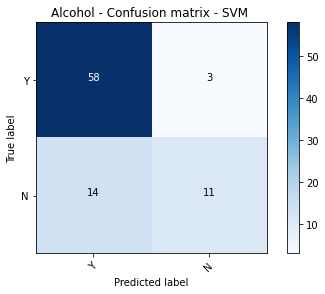

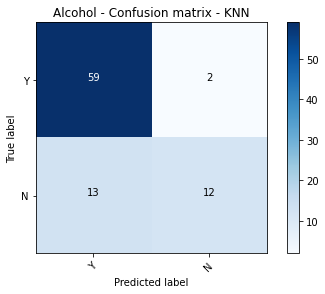

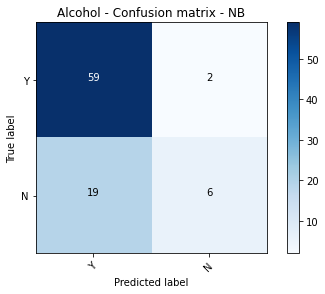

In [30]:
c11 = confusion_matrix(svmy1,svmp1)
c21 = confusion_matrix(knny1,knnp1)
c31 = confusion_matrix(nby1,nbp1)
class_names = ['Y', 'N']
plt.figure()
plot_confusion_matrix(c11, classes=class_names,normalize=False,title='Alcohol - Confusion matrix - SVM ')
plt.figure()
plot_confusion_matrix(c21, classes=class_names,normalize=False,title='Alcohol - Confusion matrix - KNN')
plt.figure()
plot_confusion_matrix(c31, classes=class_names,normalize=False,title='Alcohol - Confusion matrix - NB')

# **2. Drug use**

In [31]:
selectlist2 =[ 'NOTE' , 'Current Drug Use', 'Note Length']
selectlist2 =[x for x in df.columns if x in selectlist2]
drug = df[selectlist2].dropna()
drug['Current Drug Use'] = np.where(drug['Current Drug Use'] == 'N', 0, 1)

drug

,NOTE,Current Drug Use,Note Length
0,ogressNote SubjectivePatient IDfemaleChief Com...,1,3355
1,ogressNote SubjectivePatient IDfemaleChief Com...,1,2566
3,HistoryChief ComplaintPatientArm Pain rightatr...,1,1499
4,ogressNote SubjectivePatient IDfemaleChief Com...,1,3435
8,Progress Note SubjectivePatient IDfemalef/uURI...,1,1052
...,...,...,...
1276,c/o painright footright 5th toebig toe painmon...,1,1669
1277,Pulmonary New Patient EvaluationLung NoduleCli...,1,3533
1279,PharmacistPatient IDmalePMHtreatmentnaiveHCVci...,1,2153
1282,Gastroenterology/Hepatology Office Visit Subje...,1,5560


In [32]:
note_len_df = drug.sort_values(by='Note Length')
plt4 = go.Scatter(x = note_len_df['Note Length'], y = drug['Current Drug Use'], mode='markers')
lyt4 = go.Layout(title="Notes Length vs. Current Drug Use", xaxis=dict(title='Notes Length'),yaxis=dict(title='Current Drug Use'))
fig4 = go.Figure(data=[plt4], layout=lyt4)
iplot(fig4)
print("Notes Length to Current Drug Use Correlation:", note_len_df['Note Length'].corr(drug['Current Drug Use']))

Notes Length to Current Drug Use Correlation: -0.3302888753913917


In [33]:
x1 = drug['NOTE']
vect = TfidfVectorizer(ngram_range = (1,2))
x_vect1 = vect.fit_transform(x1)

y2 = drug['Current Drug Use']
y2

0       1
1       1
3       1
4       1
8       1
       ..
1276    1
1277    1
1279    1
1282    1
1284    1
Name: Current Drug Use, Length: 356, dtype: int64

In [34]:
svmy2,svmp2 = linsvc(x_vect1,y2)
knny2,knnp2 = revknn(x_vect1,y2)
nby2,nbp2 = revnb(x_vect1,y2)

### Linear SVC: ###
Accuracy: 84.27 %
F1 score: 90.54 %
Precision: 100.0 %
Recall: 82.72 % 

### kNN: ###
Accuracy: 77.53 %
F1 score: 83.87 %
Precision: 77.61 %
Recall: 91.23 % 

### Naive Bayes: ###
Accuracy: 83.15 %
F1 score: 89.93 %
Precision: 100.0 %
Recall: 81.71 % 



Confusion matrix, without normalization
[[ 8 14]
 [ 0 67]]
Confusion matrix, without normalization
[[17  5]
 [15 52]]
Confusion matrix, without normalization
[[ 7 15]
 [ 0 67]]


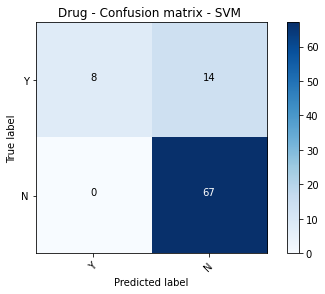

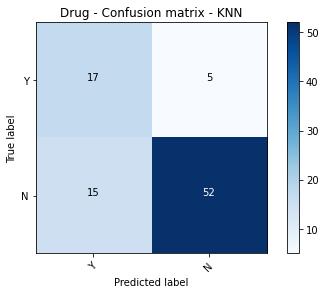

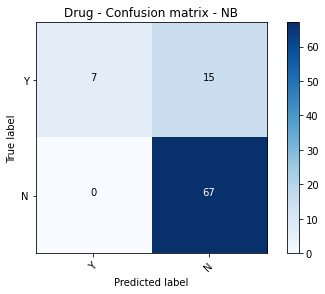

In [35]:
c12 = confusion_matrix(svmy2,svmp2)
c22 = confusion_matrix(knny2,knnp2)
c32 = confusion_matrix(nby2,nbp2)
class_names = ['Y', 'N']
plt.figure()
plot_confusion_matrix(c12, classes=class_names,normalize=False,title='Drug - Confusion matrix - SVM ')
plt.figure()
plot_confusion_matrix(c22, classes=class_names,normalize=False,title='Drug - Confusion matrix - KNN')
plt.figure()
plot_confusion_matrix(c32, classes=class_names,normalize=False,title='Drug - Confusion matrix - NB')

# **3. Current Smoker**

In [36]:
selectlist3 =[ 'NOTE' , 'Current Smoker', 'Note Length']
selectlist3 =[x for x in df.columns if x in selectlist3]
smoker = df[selectlist3].dropna()
smoker['Current Smoker'] = np.where(smoker['Current Smoker'] == 'N', 0, 1)

smoker

,NOTE,Current Smoker,Note Length
0,ogressNote SubjectivePatient IDfemaleChief Com...,1,3355
1,ogressNote SubjectivePatient IDfemaleChief Com...,1,2566
3,HistoryChief ComplaintPatientArm Pain rightatr...,1,1499
4,ogressNote SubjectivePatient IDfemaleChief Com...,1,3435
9,Progress Note SubjectivePatient IDfemaleChief ...,1,2197
...,...,...,...
1223,Tylenolmdsacolicknotifiedpending bloodurine cu...,1,2485
1224,ORTHOPAEDICS DAILYNOTEDaysPost-Op *Left* ORIFF...,1,2859
1225,MEDICINEPHYSICIANDischarge datePhysicianNo att...,1,3896
1247,RENAL ProgressPatient IDRmalePMH/oHTNs/p chron...,0,2447


In [40]:
note_len_df = smoker.sort_values(by='Note Length')
plt5 = go.Scatter(x = note_len_df['Note Length'], y = smoker['Current Smoker'], mode='markers')
lyt5 = go.Layout(title="Notes Length vs. Current Smoker", xaxis=dict(title='Notes Length'),yaxis=dict(title='Current Smoker'))
fig5 = go.Figure(data=[plt5], layout=lyt5)
fig5.show()
print("Notes Length to Current Smoker Correlation:", note_len_df['Note Length'].corr(smoker['Current Smoker']))

Notes Length to Current Smoker Correlation: 0.05503611507481271


In [38]:
x1 = smoker['NOTE']
vect = TfidfVectorizer(ngram_range = (1,2))
x_vect1 = vect.fit_transform(x1)

y3 = smoker['Current Smoker']
y3

0       1
1       1
3       1
4       1
9       1
       ..
1223    1
1224    1
1225    1
1247    0
1278    0
Name: Current Smoker, Length: 349, dtype: int64

In [41]:
svmy3,svmp3 = linsvc(x_vect1,y3)
knny3,knnp3 = revknn(x_vect1,y3)
nby3,nbp3 = revnb(x_vect1,y3)


### Linear SVC: ###
Accuracy: 93.18 %
F1 score: 96.39 %
Precision: 100.0 %
Recall: 93.02 % 

### kNN: ###
Accuracy: 87.5 %
F1 score: 92.62 %
Precision: 86.25 %
Recall: 100.0 % 

### Naive Bayes: ###
Accuracy: 90.91 %
F1 score: 95.24 %
Precision: 100.0 %
Recall: 90.91 % 



Confusion matrix, without normalization
[[ 2  6]
 [ 0 80]]
Confusion matrix, without normalization
[[ 8  0]
 [11 69]]
Confusion matrix, without normalization
[[ 0  8]
 [ 0 80]]


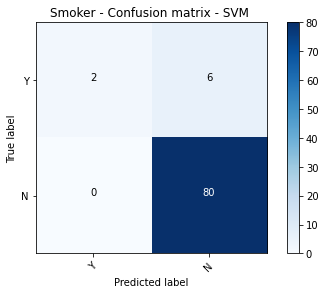

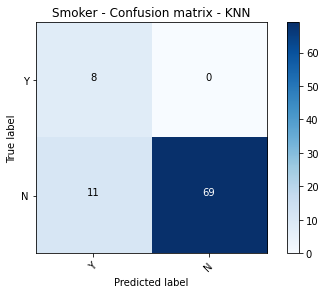

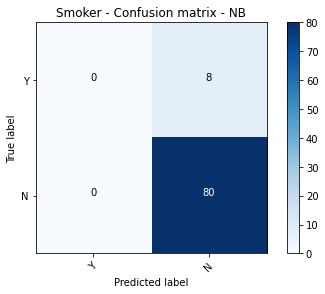

In [42]:
c13 = confusion_matrix(svmy3,svmp3)
c23 = confusion_matrix(knny3,knnp3)
c33 = confusion_matrix(nby3,nbp3)
class_names = ['Y', 'N']
plt.figure()
plot_confusion_matrix(c13, classes=class_names,normalize=False,title='Smoker - Confusion matrix - SVM ')
plt.figure()
plot_confusion_matrix(c23, classes=class_names,normalize=False,title='Smoker - Confusion matrix - KNN')
plt.figure()
plot_confusion_matrix(c33, classes=class_names,normalize=False,title='Smoker - Confusion matrix - NB')